# Label and Track Voids
Our first step in gathering the 3D positions of voids is to identify their location in each image of the tilt series, then track their movement across each image.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colormaps
from rtdefects.drift import compute_drifts_from_images_multiref, subtract_drift_from_images
from rtdefects.segmentation.pytorch import PyTorchSemanticSegmenter
from rtdefects.analysis import analyze_defects, convert_to_per_particle, compile_void_tracks
from rtdefects.io import load_file
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import trackpy as tp
import pandas as pd
import numpy as np

/home/lward/miniconda3/envs/rtdefects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TODO: Convert from pixels to nm

## Load the Images
Get the names of positions of each image

In [2]:
images = []
for image in Path('images/').glob('tilt*.png'):
    images.append({
        'path': str(image),
        'frame': int(image.name[4:-4])
    })
images = pd.DataFrame(images).sort_values('frame', ignore_index=True)
print(f'Loaded {len(images)} from tilt series')

Loaded 10 from tilt series


## Segment them
Use the latest model from the void segmentation approach. The procedure for analyzing a single image is to:

1. Load image from disk into a standard representation: grayscale represented as a floating point between 0-1
2. Convert image into the form needed by a particular model
3. Run segmentation to get the pixels for each void
4. Run analysis to get a summary of the positions, sizes, etc for each void

In [3]:
segmenter = PyTorchSemanticSegmenter()
print(f'Loaded the {segmenter.model_path.name} segmentation model.')

Loaded the small_voids_031023.pth segmentation model.


In [4]:
results = []
for path in tqdm(images['path']):
    img = load_file(path)
    std_img = segmenter.transform_standard_image(img)
    labeled_img = segmenter.perform_segmentation(std_img)
    result = analyze_defects(labeled_img)
    result['labeled_img'] = labeled_img
    results.append(result)
results = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.05s/it]


In [5]:
images = pd.concat([images, results], axis=1)

We now have the locations and sizes of voids for each frame

## Use FFT-based Drift Correction
The drift between frames in a tilt series is large and FFTs provide a robust way to determine a drift between frames

In [6]:
def convert_labeled_image_to_mask(labeled_img: np.ndarray) -> np.ndarray:
    """Convert a labeled image to a 2D boolean array

    Args:
        labeled_img: Image to be converted
    Returns:
        A simple mask
    """
    return labeled_img.any(axis=0).astype(float)

In [7]:
images['mask'] = images['labeled_img'].apply(convert_labeled_image_to_mask)

Get the drift between all pairs of frames

In [8]:
drifts = compute_drifts_from_images_multiref(images['mask'], lookahead=np.arange(8) + 1)

Plot them atop each other

In [9]:
images['shifted_mask'] = subtract_drift_from_images(images['mask'], drifts)

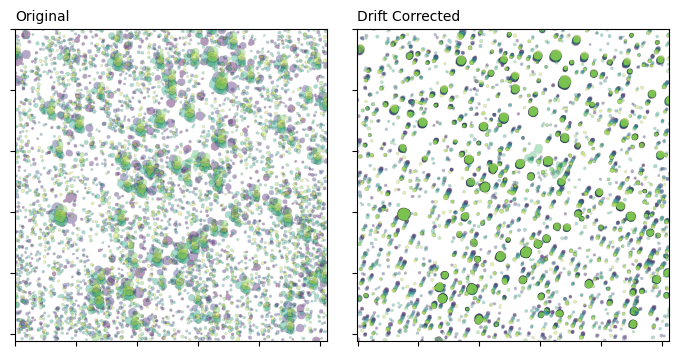

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

cmap = colormaps['viridis']
for i, (mask, mask_shifted, drift) in enumerate(zip(images['mask'], images['shifted_mask'], drifts)):
    # Plot the undrifted side
    image = np.zeros((*mask.shape, 4))
    is_object = (mask > 0)
    image[is_object, :] = cmap(i / len(results), alpha=0.4)
    axs[0].imshow(image)
    
    # Plot the drift corrected
    image = np.zeros((*mask.shape, 4))
    is_object = (mask_shifted > 0)
    image[is_object, :] = cmap(i / len(results), alpha=0.4)

    axs[1].imshow(image)

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

axs[0].set_title('Original', loc='left', fontsize=10)
axs[1].set_title('Drift Corrected', loc='left', fontsize=10)

fig.tight_layout()
fig.savefig('images/all-frames-atop.png', dpi=320)

Adjust the positions using the computed drift

In [11]:
images['positions-no-drift'] = images.apply(lambda x: np.subtract(x['positions'], drifts[x['frame'] - 1, :]), axis=1)

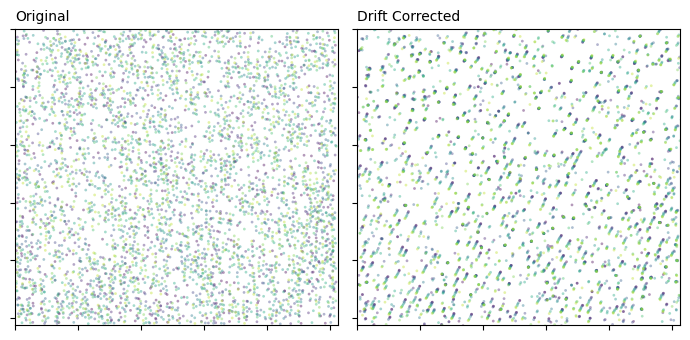

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

cmap = colormaps['viridis']
for i, (_, frame) in enumerate(images.iterrows()):
    color = cmap(i / len(results), alpha=0.4)
    axs[0].scatter(*frame['positions'].T, color=color, s=4, ec='none')
    axs[1].scatter(*frame['positions-no-drift'].T, color=color, s=4, ec='none')

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim([0, 1024])
    ax.set_ylim([1024, 0])

axs[0].set_title('Original', loc='left', fontsize=10)
axs[1].set_title('Drift Corrected', loc='left', fontsize=10)

fig.tight_layout()
fig.savefig('images/all-postions-atop.png', dpi=320)

## Run the Particle Tracking
We use [trackpy](https://soft-matter.github.io/trackpy/dev/), which expects each row in the dataframe to be a particle rather than a frame

In [13]:
particles = pd.concat(list(convert_to_per_particle(images, position_col='positions-no-drift'))).query('not touches_side')
particles.head(5)

,x,y,local_id,frame,radius,touches_side
1,471.032054,70.862995,1,0,5.670035,False
2,233.641346,76.425321,2,0,6.102643,False
3,328.297359,77.166021,3,0,6.723095,False
4,538.585244,76.980169,4,0,6.506552,False
5,172.579337,88.542602,5,0,11.170384,False


Run the tracking, using a wide search range for the drift of a single void and no memory for voids being lost between frames.

Rationale: We are only looking for a few easy-to-track particles to use when determining the tilt axis

In [14]:
tracks = tp.link_df(particles, search_range=20, memory=2)
print(f'Found a total of {len(tracks.particle.value_counts())} unique particles out of {len(particles)} labelled.')

Frame 9: 550 trajectories present.
Found a total of 1110 unique particles out of 4417 labelled.


The output is the void in each frame assigned with a global ID, "particle"

In [15]:
tracks

,x,y,local_id,frame,radius,touches_side,particle
1,471.032054,70.862995,1,0,5.670035,False,0
251,488.234295,817.063141,251,0,9.965575,False,1
250,48.791071,807.144643,250,0,4.222008,False,2
249,23.624755,806.481127,249,0,4.029120,False,3
248,746.287500,805.619167,248,0,4.886025,False,4
...,...,...,...,...,...,...,...
191,282.900379,365.378409,191,9,4.583498,False,999
192,321.143364,370.015895,192,9,7.180961,False,320
193,871.129354,369.034691,193,9,5.322554,False,732
187,148.482870,354.435648,187,9,5.863230,False,329


We'll next produce a summary where we group the same particule into each row

In [16]:
void_tracks = compile_void_tracks(tracks)
void_tracks.sort_values('total_frames', ascending=False).head()

,start_frame,end_frame,total_frames,inferred_frames,positions,touches_side,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
196,0,9,10,0,"[[959.026360103627, 216.40990932642487], [963....","[False, False, False, False, False, False, Fal...","[51, 85, 79, 80, 83, 114, 118, 106, 84, 111]","[0.0, 4.42952486026688, 4.817683759542531, 7.7...",7.740870,0.774087,"[0.0, 4.42952486026688, 5.899723975730944, 9.0...",17.589498,1.758950,"[7.837972188868215, 11.699284211396439, 11.821...",12.691131,7.837972,0.225701
289,0,9,10,0,"[[790.6050115207374, 541.1429147465437], [790....","[False, False, False, False, False, False, Fal...","[159, 211, 204, 206, 216, 265, 281, 243, 213, ...","[0.0, 0.7249836342963236, 1.2988680040493323, ...",4.964725,0.496473,"[0.0, 0.7249836342963236, 1.2989831137796604, ...",10.461191,1.046119,"[11.753573524837677, 12.179179240065665, 11.96...",12.179179,8.648863,-0.090297
153,0,9,10,0,"[[255.9143292682927, 898.3149390243902], [255....","[False, False, False, False, False, False, Fal...","[288, 376, 346, 362, 384, 458, 491, 439, 389, ...","[0.0, 2.8835360933811685, 4.1979146406693015, ...",12.682009,1.268201,"[0.0, 2.8835360933811685, 5.2510826024323425, ...",17.727299,1.772730,"[5.108953969950291, 7.918778161951929, 8.11727...",9.474354,5.108954,0.248119
287,0,9,10,2,"[[233.175, 480.3142857142857], [233.2534883720...","[False, False, False, False, False, False, Fal...","[140, 190, 186, 180, 192, 238, None, None, 199...","[0.0, 0.5717474296723579, 1.938860434107509, 6...",19.649100,1.964910,"[0.0, 0.5717474296723579, 2.0306139243058103, ...",22.588048,2.258805,"[5.970821321441846, 6.407961869245868, 4.25953...",6.407962,4.259538,-0.127044
155,0,9,10,4,"[[601.4630102040817, 936.1573979591836], [602....","[False, False, False, False, False, False, Fal...","[301, 391, 358, None, 402, None, None, 452, No...","[0.0, 0.9301764465696519, 1.3043956336309213, ...",3.776562,0.377656,"[0.0, 0.9301764465696519, 1.860305017653967, 4...",11.822386,1.182239,"[8.83096382707056, 9.321941800299703, 10.21790...",10.217908,6.909883,0.033076


Plot the tracks for the voids

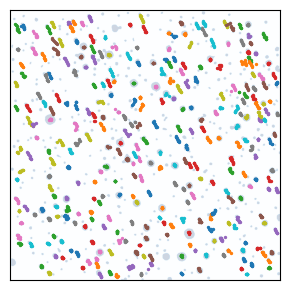

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.imshow(mask_shifted, cmap='Blues', alpha=0.2, origin='lower')
ax.set_yticks(ax.set_xticks([]))
for p in void_tracks.query('total_frames > 7')['positions']: 
    ax.scatter(p[:, 0], p[:, 1], s=2)

ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])

fig.tight_layout()

We've got some noticeable differences in drift as a function of position on the image

## Save for later use
Let's save a few things separately.

First, the data for each frame

In [18]:
results.drop(columns=['labeled_img']).to_json('frame-data.json', orient='records', lines=True)

Then the summary of void tracks, in full detail

In [19]:
void_tracks.to_json('track-data.json', orient='records', lines=True)

Now the CSV of voids that are tracked across many frames coordinates in 2D

In [20]:
tracked_coords = defaultdict(list)
for rid, row in void_tracks.query('total_frames >= 8').iterrows():
    for i, (x, y) in enumerate(row['positions']):
        tracked_coords['id'].append(rid)
        tracked_coords['frame'].append(i + row['start_frame'])
        tracked_coords['x'].append(x)
        tracked_coords['y'].append(y)
    tracked_coords['r'].extend(row['radii'])
tracked_coords = pd.DataFrame(tracked_coords)

In [21]:
tracked_coords.to_csv('void-2d-coordinates.csv', index=False)